In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:06<00:00, 161MB/s]
100% 1.33G/1.33G [00:06<00:00, 206MB/s]


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile
output = "generated_images" # Folder for generated images over epochs
os.mkdir(output)


In [4]:
!unzip celeba-dataset.zip -d ./dataset

Streaming output truncated to the last 5000 lines.
  inflating: ./dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: ./dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: ./dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: ./dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: ./dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: ./dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: ./dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: ./dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: ./dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: ./dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: ./dataset/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: ./dataset/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: ./dataset/img_align_celeba/img_align_celeba/197617.jpg  
  inflating: ./dataset/img_align_celeba

In [21]:
dataset_directory = "./dataset"
dataset = keras.preprocessing.image_dataset_from_directory(
    dataset_directory, label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 202599 files belonging to 1 classes.


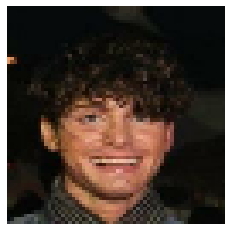

In [22]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [23]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)            

In [24]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_4 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 32, 32, 256)      524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 32, 32, 256)       0 

In [25]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [26]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(f"{output}/generated_img_%03d_%d.png" % (epoch, i))

In [29]:
epochs = 3  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

callbacks = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/3
6332/6332 [==============================] - 1819s 287ms/step - d_loss: 0.6080 - g_loss: 1.2123
Epoch 2/3
6332/6332 [==============================] - 1816s 287ms/step - d_loss: 0.6514 - g_loss: 1.0400
Epoch 3/3
6332/6332 [==============================] - 1816s 287ms/step - d_loss: 0.6679 - g_loss: 0.9845


In [30]:
generator.save('gen.h5')
discriminator.save('disc.h5')

In [31]:
image_name = "user_input" # Enter name for output image files
num_img = 10 # Number of images to be generated
latent_dim = 128 # Latent Dimension
random_latent_vectors = tf.random.normal(shape=(num_img, latent_dim)) # Create random noise vector
generated_images = generator(random_latent_vectors) # Insert noise in generator
generated_images *= 255 # denormalise image
generated_images.numpy() # convert image to numpy
for i in range(num_img):
    img = keras.preprocessing.image.array_to_img(generated_images[i]) # Convery image to array
    img.save("generated_img_%s_%d.png" % (image_name, i)) # Save image

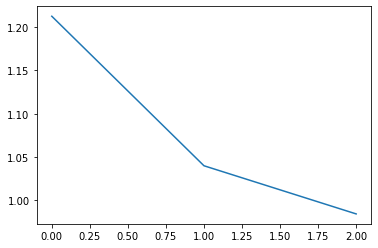

In [35]:
plt.plot(callbacks.history['g_loss'])